# Predicción de la producción de energía éolica con SKlearn.

Este código pertenece a la primera práctica de la asignutra de Aprendizaje Automático.

100471948 - Celia Patricio Ferrer

100472039 - Alberto García de la Torre

### Librerías necesarias.

In [1]:
# Datos
import time
import numpy as np
import pandas as pd
from sklearn import metrics

# Graficos
import seaborn as sns
import matplotlib.pyplot as plt

# Modelos
from sklearn import tree
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from lineartree import LinearTreeRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import MaxAbsScaler, QuantileTransformer

# HPO
from sklearn.model_selection import RandomizedSearchCV, KFold, GridSearchCV
from scipy.stats import randint as sp_randint

# Warnings
import warnings
warnings.filterwarnings('ignore')       # ignorar warnings
warnings.filterwarnings('once')          # mostrar una vez

---
## Lectura del archivo.
---

En primer lugar se lee el archivo que contiene los datos disponibles. Es decir, se realiza la lectura del archivo csv llamado *wind_ava.csv.gz*.

In [2]:
wind_ava = pd.read_csv('wind_ava.csv.gz', compression="gzip")

# Imprimir el dataframe.
print(wind_ava)

                 datetime   energy     p54.162.1     p54.162.2     p54.162.3  \
0     2005-01-02 18:00:00   402.71  2.534970e+06  2.526864e+06  2.518754e+06   
1     2005-01-03 00:00:00   696.80  2.537369e+06  2.529277e+06  2.521184e+06   
2     2005-01-03 06:00:00  1591.15  2.533727e+06  2.525703e+06  2.517678e+06   
3     2005-01-03 12:00:00  1338.62  2.534491e+06  2.526548e+06  2.518609e+06   
4     2005-01-03 18:00:00   562.50  2.529543e+06  2.521623e+06  2.513702e+06   
...                   ...      ...           ...           ...           ...   
4743  2009-12-30 06:00:00  1280.13  2.407224e+06  2.400131e+06  2.393033e+06   
4744  2009-12-30 12:00:00   855.00  2.407234e+06  2.400117e+06  2.393001e+06   
4745  2009-12-30 18:00:00   117.06  2.401034e+06  2.393683e+06  2.386332e+06   
4746  2009-12-31 12:00:00   516.96  2.393873e+06  2.386499e+06  2.379125e+06   
4747  2009-12-31 18:00:00   867.07  2.392305e+06  2.384669e+06  2.377033e+06   

         p54.162.4     p54.162.5     p5

Como podemos ver, este dataset está formado por 4748 instancias y 552 atributos.

---
## Filtrado de datos.
---

Se deben quitar las variables metereológicas que no correspondan a la localización de Sotavento, la localización 13.

Estas variables serán las **variables de entrada** de nuestro problema.

In [3]:
X_df = wind_ava.filter(regex='.13$')
# Imprimir el dataframe.
print(X_df)

        p54.162.13  p55.162.13    cape.13    p59.162.13  lai_lv.13  lai_hv.13  \
0     2.510824e+06    9.186295  13.527577  1.386937e+06   2.344111   2.432983   
1     2.513173e+06    8.849569   6.896412  1.153526e+06   2.343719   2.432838   
2     2.509627e+06    7.924080   4.774439  1.098754e+06   2.343300   2.432704   
3     2.510571e+06    6.922709   0.000000  1.076021e+06   2.342830   2.432514   
4     2.505664e+06    6.646282   0.000000  1.070830e+06   2.342437   2.432369   
...            ...         ...        ...           ...        ...        ...   
4743  2.385772e+06   14.413342  24.971074  3.905586e+06   2.349839   2.434994   
4744  2.385708e+06   12.802883  60.248874  2.745694e+06   2.349446   2.434849   
4745  2.379049e+06   10.915997   3.145067  2.254171e+06   2.349054   2.434715   
4746  2.371697e+06   13.048144  12.580268  1.376913e+06   2.347799   2.434291   
4747  2.369547e+06    9.172745   8.487892  1.356687e+06   2.347406   2.434145   

       u10n.13   v10n.13   

¿Por qué nos hemos cargado `datetime`?

In [4]:
# Imprimir el tamaño del dataframe.
print(X_df.shape)

(4748, 22)


In [5]:
# Imprimir las primeras filas del dataframe.
print(X_df.head())

     p54.162.13  p55.162.13    cape.13    p59.162.13  lai_lv.13  lai_hv.13  \
0  2.510824e+06    9.186295  13.527577  1.386937e+06   2.344111   2.432983   
1  2.513173e+06    8.849569   6.896412  1.153526e+06   2.343719   2.432838   
2  2.509627e+06    7.924080   4.774439  1.098754e+06   2.343300   2.432704   
3  2.510571e+06    6.922709   0.000000  1.076021e+06   2.342830   2.432514   
4  2.505664e+06    6.646282   0.000000  1.070830e+06   2.342437   2.432369   

    u10n.13   v10n.13         sp.13     stl1.13  ...      t2m.13     stl2.13  \
0 -0.757587 -1.922799  99846.319914  280.960661  ...  280.473098  281.042026   
1 -1.412620 -1.403011  99917.733093  279.296651  ...  278.286616  280.747406   
2 -2.290185 -0.754580  99764.378681  278.233956  ...  277.206490  280.114863   
3 -3.497855  1.271028  99672.670459  280.787263  ...  280.926600  279.991138   
4 -0.971249  0.553060  99372.811211  279.583112  ...  277.363875  280.576898   

      stl3.13   iews.13   inss.13     stl4.13    f

In [6]:
# Imprimir el tipo de atributos.
X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4748 entries, 0 to 4747
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   p54.162.13  4748 non-null   float64
 1   p55.162.13  4748 non-null   float64
 2   cape.13     4748 non-null   float64
 3   p59.162.13  4748 non-null   float64
 4   lai_lv.13   4748 non-null   float64
 5   lai_hv.13   4748 non-null   float64
 6   u10n.13     4748 non-null   float64
 7   v10n.13     4748 non-null   float64
 8   sp.13       4748 non-null   float64
 9   stl1.13     4748 non-null   float64
 10  u10.13      4748 non-null   float64
 11  v10.13      4748 non-null   float64
 12  t2m.13      4748 non-null   float64
 13  stl2.13     4748 non-null   float64
 14  stl3.13     4748 non-null   float64
 15  iews.13     4748 non-null   float64
 16  inss.13     4748 non-null   float64
 17  stl4.13     4748 non-null   float64
 18  fsr.13      4748 non-null   float64
 19  flsr.13     4748 non-null  

Para determinar si el problema es de regresión o de clasificación. 

- Si se trata de un problema de clasificación o de regresión (variable de salida es una clase o un valor continuo), y en caso de clasificación, si la clase está desequilibrada.

En nuestro caso, la **varible de salida** es *energy*.

In [7]:
# Imprimir los primeros valores la variable de salida.
y_df = wind_ava['energy']
print(y_df.head())

0     402.71
1     696.80
2    1591.15
3    1338.62
4     562.50
Name: energy, dtype: float64


Obtenemos que son valores númericos de salida, lo que significa que se trata de un **problema de reglesión**.

---
## Análisis Exploratorio de Datos Simplificado.
---

### Variables.

Identificar qué varibles son categóricas y qué variables son numéricas.

In [8]:
categoricas = X_df.select_dtypes(include=['object']).columns
numericas = X_df.select_dtypes(exclude=['object']).columns

# Imprimir por pantalla dicho resultado.
print("Variables categóricas:", categoricas)
print("Variables numéricas:", numericas)

Variables categóricas: Index([], dtype='object')
Variables numéricas: Index(['p54.162.13', 'p55.162.13', 'cape.13', 'p59.162.13', 'lai_lv.13',
       'lai_hv.13', 'u10n.13', 'v10n.13', 'sp.13', 'stl1.13', 'u10.13',
       'v10.13', 't2m.13', 'stl2.13', 'stl3.13', 'iews.13', 'inss.13',
       'stl4.13', 'fsr.13', 'flsr.13', 'u100.13', 'v100.13'],
      dtype='object')


Obtenemos que todas las variables son numéricas, es decir, son características o atributos numéricos.

Análisis completo de cada variable.

In [9]:
resultados = []

for variable in X_df.columns:
    summary = X_df[variable].describe()
    mean = summary['mean']
    std_dev = summary['std']
    variance = std_dev**2
    resultados.append([variable, mean, std_dev, variance])

# Convertir la lista de listas en un DataFrame y mostrarlo
df_resultados = pd.DataFrame(resultados, columns=["Variable", "Media", "Desviación típica", "Varianza"]).sort_values(by="Varianza", ascending=True)
pd.set_option('display.max_colwidth', None)
display(df_resultados)


,Variable,Media,Desviación típica,Varianza
18,fsr.13,4.136772e-01,7.602132e-03,5.779241e-05
19,flsr.13,-5.908467e+00,9.435944e-02,8.903704e-03
5,lai_hv.13,2.576284e+00,1.164342e-01,1.355691e-02
15,iews.13,7.422920e-02,3.670135e-01,1.346989e-01
16,inss.13,4.997084e-02,3.790142e-01,1.436517e-01
4,lai_lv.13,2.815222e+00,3.973773e-01,1.579087e-01
7,v10n.13,1.205277e-01,3.016766e+00,9.100875e+00
11,v10.13,1.671045e-01,3.058615e+00,9.355127e+00
6,u10n.13,3.862152e-01,3.100583e+00,9.613612e+00
10,u10.13,3.030704e-01,3.158104e+00,9.973619e+00


Con el cálculo de la relación Varianza/Media, identificamos la dispersión relativa que hay de los datos en relación con su valor promedio. Tras analizar uno por uno todos los valores, hemos considerado que las siguientes variables tenían una relación muy baja:
- fsr.13
- flsr.13
- lai_hv.13
- iews.13
- inss.13
- lai_lv.13

### Número de características e instancias.

In [10]:
# Imprimir la cantidad de característica e instancias del dataframe.
print("Nº de características: ", X_df.shape[1])
print("Nº de instancias: ", X_df.shape[0])

Nº de características:  22
Nº de instancias:  4748


Es decir, el dataset está formado por 4748 instancias y 22 atributos o características.

### Valores faltantes.

En esta sección se especifica si hay valores faltantes (*missing values*) y qué variables los tienen.

In [11]:
# Imprimir la cantidad de valores faltantes por variable.
print(X_df.isnull().sum())

p54.162.13    0
p55.162.13    0
cape.13       0
p59.162.13    0
lai_lv.13     0
lai_hv.13     0
u10n.13       0
v10n.13       0
sp.13         0
stl1.13       0
u10.13        0
v10.13        0
t2m.13        0
stl2.13       0
stl3.13       0
iews.13       0
inss.13       0
stl4.13       0
fsr.13        0
flsr.13       0
u100.13       0
v100.13       0
dtype: int64


Como podemos ver, no hay ninguna variable con valores faltantes.

### Columnas constantes.

Evualuación de columnas constantes y en caso de haberlas, eliminarlas.

In [12]:
columnas_constantes = X_df.columns[X_df.nunique() == 1]
X_df = X_df.drop(columnas_constantes, axis=1)
print("Columnas constantes eliminadas:", columnas_constantes)

Columnas constantes eliminadas: Index([], dtype='object')


Como podemos ver, no hay columnas constantes. Sin embargo, como hemos calculado anteriormente, hay algunas columnas con varianza muy pequeña, las tendremos en cuenta posteriormente.

### Correlación de variables

En esta sección, analizaremos la correlación que pueda existir entre las variables, incluyendo la variable de salida. Esto lo realizaremos a través de la matriz de correlación. Y destacaremos aquellas variables con una alta correlación para tenerlas en cuenta posteriormente.

<Axes: >

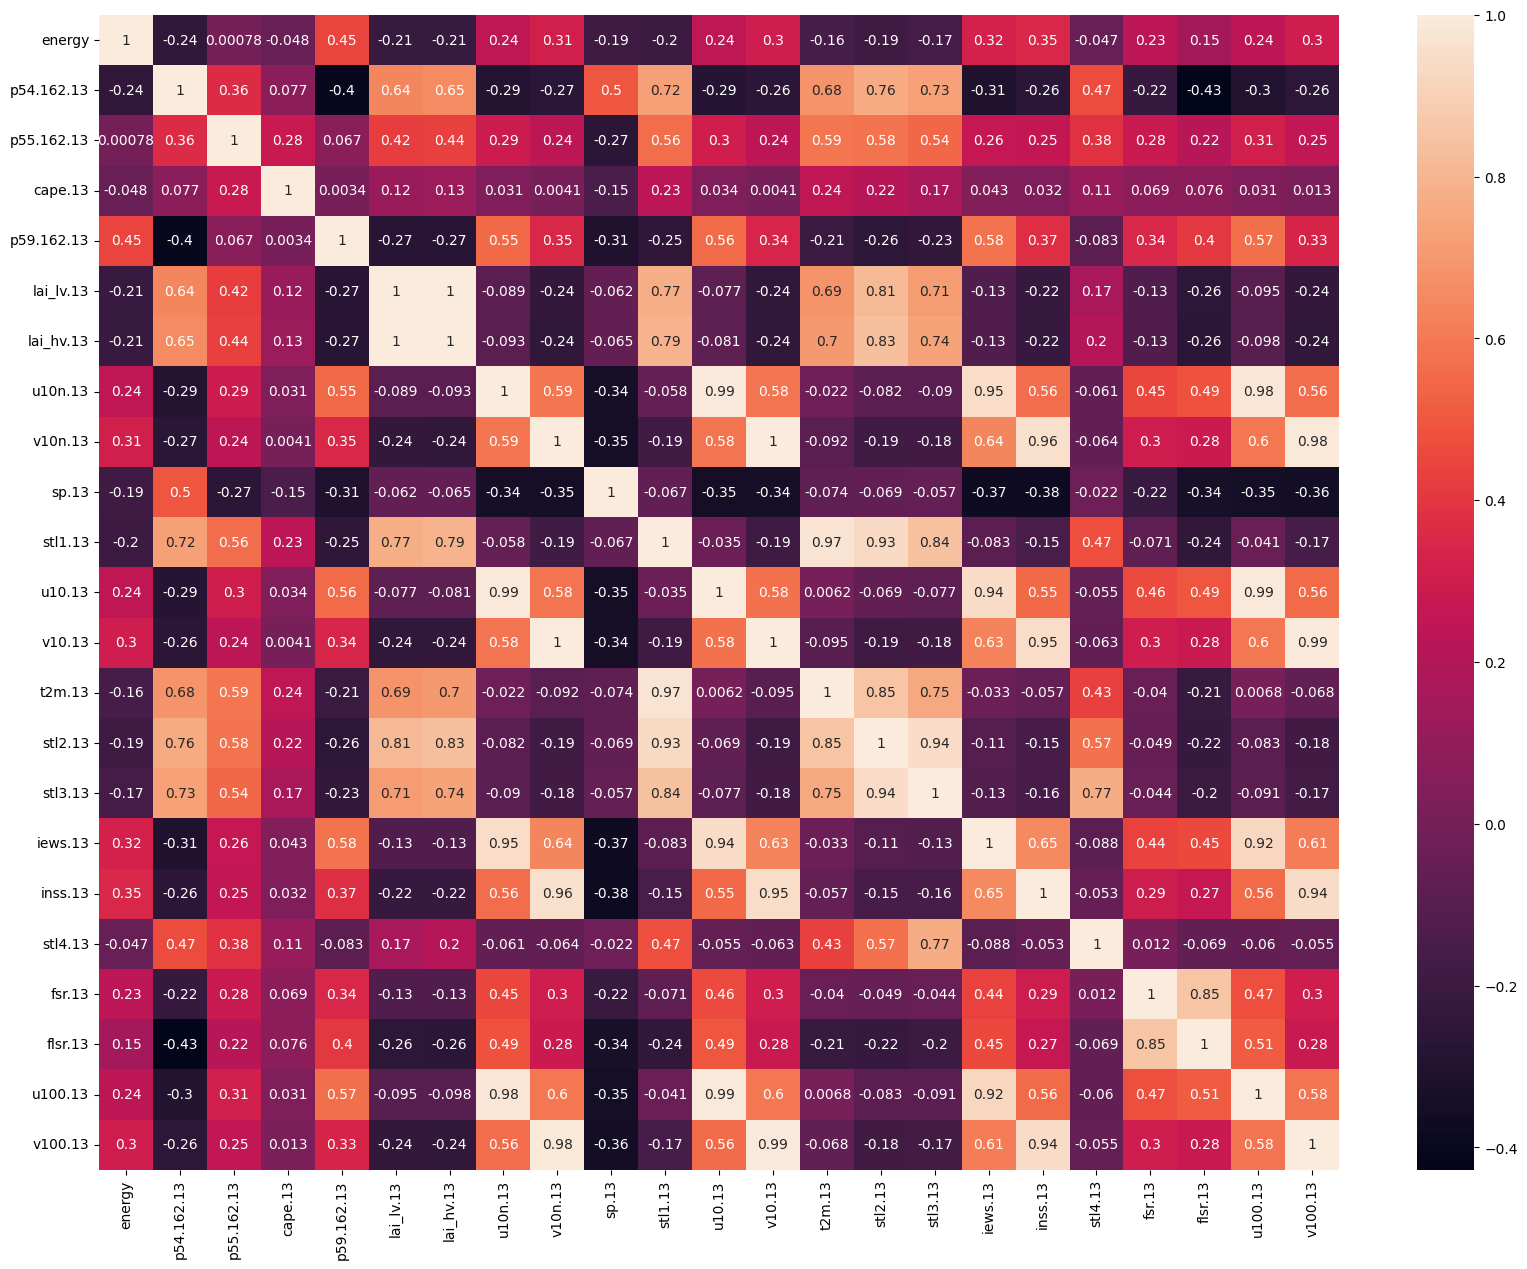

In [13]:
# Creamos la matriz de correlación
plt.figure(figsize=(20, 15))
copia = X_df.copy()
copia.insert(0, 'energy', wind_ava['energy'])
correlation_matrix = copia.corr()
sns.heatmap(data=correlation_matrix, annot=True)

En cuanto a la correlación negativa, ningún par de variables presentan dicha correlación, ya que ninguna rebaja el -0.4. Sin embargo, hay algunos pares de variables que muestran una alta correlación positiva. Y estos son los siguientes:
- u10 - u10n
- v10 - v10n
- lai_lv - lai_hv
- u10n - iews
- u100 - iews
- v100 - inss
- stl2 - stl3
- u100 - u10
- v100 - v10
- u100 - u10n
- v100 - v10n
- flsr - fsr
- lai_lv - stl2
- lai_hv - stl2

Mientras que entre las variables de entrada con la variable de salida (*energy*), no se aprecia una alta correlación.

Con las siguientes gráficas verificamos visualmente la correlación entre las variables de entrada. Para ello, veremos dibujadas la relación que existe entre la variable v10 y en función de la variable v10n. 

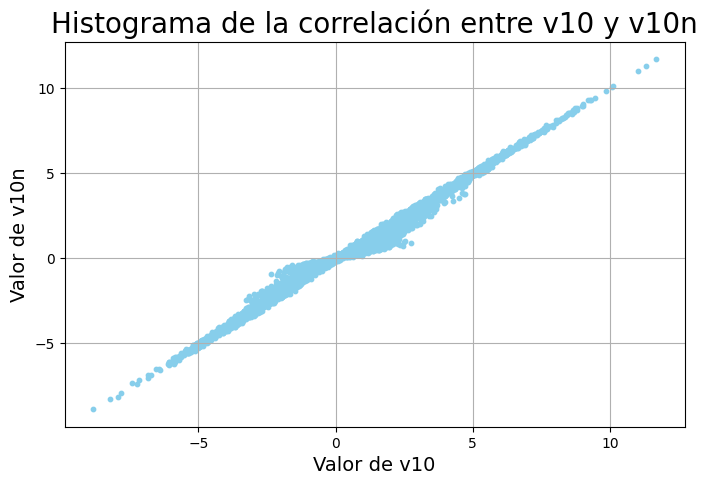

In [14]:
plt.figure(figsize=(8, 5))
plt.scatter(wind_ava['v10.13'], wind_ava["v10n.13"], color='skyblue', marker='o', s=10)
plt.title('Histograma de la correlación entre v10 y v10n', size=20)
plt.xlabel('Valor de v10', size=14)
plt.ylabel('Valor de v10n', size=14)
plt.grid(True)
plt.show()

Como podemos ver, esta gráfica nos confirma que tienen una alta relación positiva, a medida que una crece, la otra también lo hace.

### Distribución de la variable de salida.

A continuación, vamos a analizar la distribución de la variable de salida, llamada *energy*.

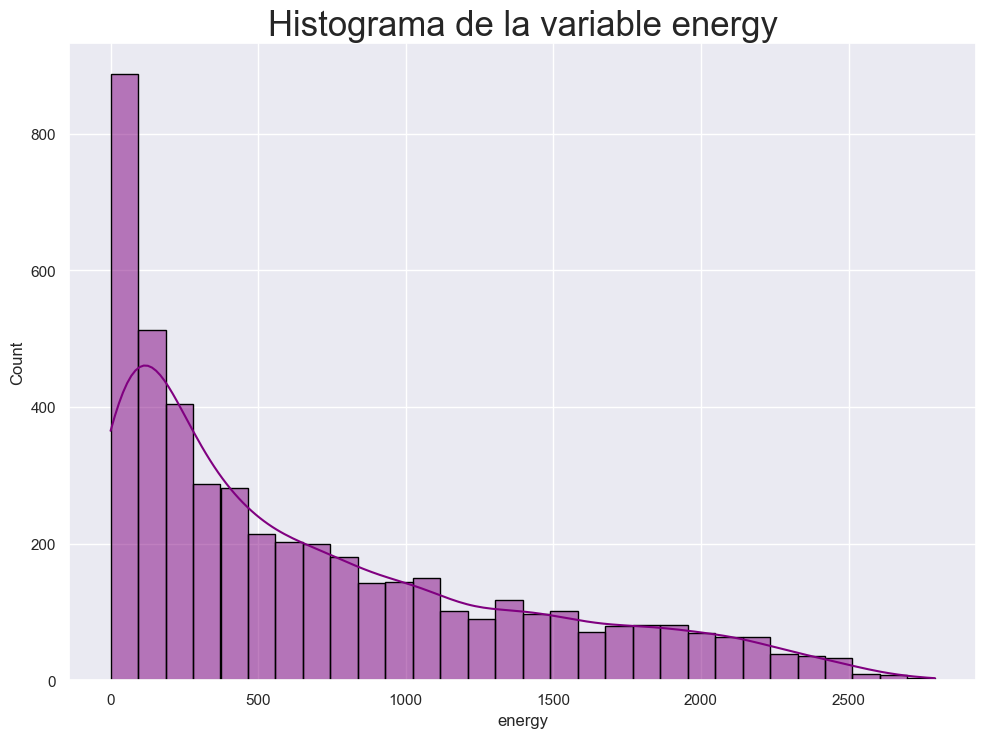

In [15]:
# Dibujamos el histograma de la variable de salida
sns.set(rc={'figure.figsize':(11.7, 8.27)})
sns.histplot(y_df, bins=30, color='purple', kde=True, edgecolor='black')
plt.title('Histograma de la variable energy', size=25)
plt.show()

Obtenemes que la distribución de esta variable es exponencial, podemos apreciar una alta frecuencia de valores de baja energía.

---
## Evaluación outer.
---

En primer lugar, realizaremos la evaluación de diferentes modelos de regresión con sus hiperparámetros por defecto. 

In [16]:
# Dividimos los datos entre entrenamiento y test.
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.33, random_state=49)

### KNN.

En primer lugar, crearemos un modelo KNN sin escalar los datos y evaluaremos el rendimiento obtenido.

In [17]:
# Creamos el modelo.
regr_knn = KNeighborsRegressor()
np.random.seed(49)
# Entrenamos el modelo.
inicio = time.time()
regr_knn.fit(X_train, y_train)
fin = time.time()
# Tiempo de entrenamiento.
t_knn_o = fin - inicio
# Realizamos las predicciones.
y_test_pred = regr_knn.predict(X_test)
# Evaluamos el rendimiento del modelo.
rmse_knn = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_knn = metrics.r2_score(y_test, y_test_pred)

# Imprimir el resultado.
print(f"RMSE: {rmse_knn}")
print(f"R2: {r2_knn}")

RMSE: 636.3288087730467
R2: 0.06026198644919867


A continuación, escalaremos los datos aplicando diferentes métodos y evaluaremos cuál es el de mejor y más apropiado para este problema. 

- *StandardScaler*: escala los datos para que tengan una media de 0 y una desviación estándar de 1.

- *MinMaxScaler*: escala los datos al intervalo especificado (por defecto [0, 1]).

- *RobustScaler*: escala los datos utilizando estadísticas robustas para manejar valores atípicos.

- *MaxAbsScaler*: escala los datos dividiendo cada característica por su valor máximo absoluto.

- *QuantileTransformer*: transforma los datos para que tengan una distribución uniforme o gaussiana.

In [18]:
def escalado(scaler):
    model = KNeighborsRegressor()
    np.random.seed(49)
    X_train_result = scaler.fit_transform(X_train)
    X_test_result = scaler.transform(X_test)
    # Entrenamos el modelo.
    inicio = time.time()
    model.fit(X_train_result, y_train)
    fin = time.time()
    tiempo = fin - inicio
    # Realizamos las predicciones.
    y_test_pred = model.predict(X_test_result)
    # Evaluamos el rendimiento del modelo.
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
    r2 = metrics.r2_score(y_test, y_test_pred)
    return rmse, r2, tiempo

In [19]:
# StandardScaler
scaler = StandardScaler()
rmse_standar, r2_standar, t_standar = escalado(scaler)
# MinMaxScaler
scaler = MinMaxScaler()
rmse_minmax, r2_minmax, t_minmax = escalado(scaler)
# RobustScaler
scaler = RobustScaler()
rmse_robust, r2_robust, t_robust = escalado(scaler)
# MaxAbsScaler
scaler = MaxAbsScaler()
rmse_maxabs, r2_maxabs, t_maxabs = escalado(scaler)
# QuantileTransformer
scaler = QuantileTransformer()
rmse_quantile, r2_quantile, t_quantile = escalado(scaler)

In [20]:
# Imprimimos en un dataframe todos los resultados.
resultados = pd.DataFrame({
    "RMSE": [rmse_knn, rmse_standar, rmse_minmax, rmse_robust, rmse_maxabs, rmse_quantile],
    "R2": [r2_knn, r2_standar, r2_minmax, r2_robust, r2_maxabs, r2_quantile],
    "Tiempo": [t_knn_o, t_standar, t_minmax, t_robust, t_maxabs, t_quantile]
}, index=["Sin escalar", "StandardScaler", "MinMaxScaler", "RobustScaler", "MaxAbsScaler", "QuantileTransformer"])
resultados


,RMSE,R2,Tiempo
Sin escalar,636.328809,0.060262,0.001696
StandardScaler,402.269009,0.624442,0.000525
MinMaxScaler,413.265640,0.603629,0.000455
RobustScaler,409.245852,0.611302,0.000424
MaxAbsScaler,406.858835,0.615823,0.000385
QuantileTransformer,421.414846,0.587842,0.000516


Finalmente obtenemos que el mejor modelo de KNN de regresión con escalado de datos es el *StandardScaler* debido a que es el que tiene el RMSE menor y el R2 más próximo a 1. Por lo tanto, este método es el que usaremos de aquí en adelante cuando sea necesario.

#### Escalado de los datos

Aplicaremos el método de escalado *StandardScaler*, debido a que es el de mejor resultado.

In [21]:
scaler = StandardScaler()
X_df = scaler.fit_transform(X_df)

Volveremos a realizar el modelo KNN, pero esta vez utilizando los datos escalados y veremos si hay alguna mejora.

#### División

Al tratarse de un problema de regresión, las métricas que se utilizarán para evaluar el rendimiento de cada modelo serán: RMSE (Error Cuadrático Medio) y R2 (Coeficiente de Determinación). Además dividiremos el conjunto de datos entre entrenamiento y test de esta forma: 2/3 y 1/3, respectivamente.

In [22]:
# Dividimos los datos entre entrenamiento y test.
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_df, y_df, test_size=0.33, random_state=49)

In [23]:
regr_knn = KNeighborsRegressor()
np.random.seed(49)
# Entrenamos el modelo.
inicio = time.time()
regr_knn.fit(X_train_scaled, y_train)
fin = time.time()
# Tiempo de entrenamiento.
t_knn = fin - inicio
# Realizamos las predicciones.
y_test_pred = regr_knn.predict(X_test_scaled)
# Evaluamos el rendimiento del modelo.
rmse_knn_scaled = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_knn_scaled = metrics.r2_score(y_test, y_test_pred)

# Imprimir el resultado.
print(f"RMSE: {rmse_knn_scaled}")
print(f"R2: {r2_knn_scaled}")

RMSE: 402.54987543666596
R2: 0.623917593835212


Mejora significativamente la precisión de las predicciones. Y aumenta considerablemente la capacidad del modelo para explicar la variabilidad en los datos. Sin embargo, esta mejora significativa no significa que sea el mejor modelo final.

### Dummy.

Regresor simple y básico para problemas de regresión. Este modelo se tomará como referencia para detectar posibles mejoras en las predicciones.

In [24]:
# Crear el modelo Dummy.
regr_dummy = DummyRegressor(strategy="median")
np.random.seed(49)
# Entrenar el modelo.
inicio = time.time()
regr_dummy.fit(X_train, y_train)
fin = time.time()
# Tiempo de entrenamiento.
t_dummy = fin - inicio
y_test_pred = regr_dummy.predict(X_test)
# Métricas de evaluación.
rmse_dummy = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_dummy = metrics.r2_score(y_test, y_test_pred)

# Imprimir el resultado.
print(f"RMSE: {rmse_dummy}")
print(f"R2: {r2_dummy}")


RMSE: 692.091301457747
R2: -0.11165597168553609


Obtenemos que con este clasificador no existe casi ajuste ya que se aleja mucho de 1, el valor deseado para R2 (el coeficiente de determinación). Mientras que para el error cuadratico medio de la raiz, RMSE, nos indica que las predicciones se desvían mucho del valor real. 

Tras este análisis, podemo concluir que este modelo está realizando unas predicciones nada útiles y que es necesario otro modelo para conseguir unas predicciones más precisas.

### Regresión lineal.

Aplicaremos el modelo de regresión lineal ordinario. En este modelo, es beneficioso que los datos estén escalados.

In [25]:
regr_lineal = LinearRegression()
np.random.seed(49)
# Entrenamos el modelo
inicio = time.time()
regr_lineal.fit(X_train_scaled, y_train)
fin = time.time()
# Tiempo de entrenamiento.
t_lineal = fin - inicio
# Obtenemos las predicciones sobre el conjunto de prueba
y_test_pred = regr_lineal.predict(X_test_scaled)
# Métricas de evaluación
rmse_lineal = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_lineal = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmse_lineal}")
print(f"R2: {r2_lineal}")

RMSE: 539.7612031414392
R2: 0.32384392553387276


Obtenemos una leve mejora con respecto al modelo nulo (Dummy).

### Árbol de decisión de regresión.

A continuación evaluaremos el modelo de árbol de decisión y evaluaremos su rendimiento.

In [26]:
regr_tree = tree.DecisionTreeRegressor()
np.random.seed(49) 
# Entrenamos el modelo.
inicio = time.time()
regr_tree.fit(X_train, y_train)
fin = time.time()
# Tiempo de entrenamiento.
t_tree = fin - inicio
y_test_pred = regr_tree.predict(X_test)
# Métricas de evaluación.
rmse_tree = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_tree = metrics.r2_score(y_test, y_test_pred)

# Imprimir el resultado.
print(f"RMSE: {rmse_tree}")
print(f"R2: {r2_tree}")


RMSE: 509.8152113241104
R2: 0.3967890698918305


Tras la realización del modelo de regresión de árbol de decisión, podemos apreciar que mejora considerablemente con respecto al Dummy y muy poco con respecto al modelo lineal, en términos de precisión de predicción. Pero, sigue sin ser el mejor modelo ya que todavía existe un margen muy grande de mejora con predicciones más precisas.

### Árbol de decisión y regresión lineal.

Como algo adicional, evaluaremos este modelo. Se trata de un modelo de regresión que combina el árbol de decisión de regresión y la regresión lineal. Es decir, al modelo anteriormente analizado, le añadiremos como parámetro *base_estimator* (el tipo de regresor que va a utilizar en los nodos terminales), la regresión lineal básica.

In [27]:
regr_linear_tree = LinearTreeRegressor(base_estimator=LinearRegression())
np.random.seed(49)
# Entrenamos el modelo
inicio = time.time()
regr_linear_tree.fit(X_train, y_train)
fin = time.time()
# Tiempo de entrenamiento
t_linear_tree = fin - inicio
# Obtenemos las predicciones sobre el conjunto de prueba
y_test_pred = regr_linear_tree.predict(X_test)
# Métricas de evaluación
rmse_linear_tree = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_linear_tree = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmse_linear_tree}")
print(f"R2: {r2_linear_tree}")

RMSE: 383.13311481655455
R2: 0.6593228508176546


Con este modelo obtenemos unos mejores resultados. Obtenemos que este modelo es mejor para predcir los valores de la variable energía con precisión. Además, consigue con una mayor proporción, explicar la variabilidad de los valores de la variable de salida.

### Regularización Ridge.

Analizaremos el modelo con regularización Ridge con valores por omisión. Es decir, sin ningún parámetro para evaluar su rendimiento.

In [28]:
regr_ridge = Ridge()
np.random.seed(49)
# Entrenamos el modelo
inicio = time.time()
regr_ridge.fit(X_train_scaled, y_train)
fin = time.time()
# Tiempo de entrenamiento
t_ridge = fin - inicio
# Obtenemos las predicciones sobre el conjunto de prueba
y_test_pred = regr_ridge.predict(X_test_scaled)
# Métricas de evaluación
rmse_ridge = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_ridge = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmse_ridge}")
print(f"R2: {r2_ridge}")

RMSE: 540.1020237918318
R2: 0.322989767408254


### Regularización Lasso.

Ahora, analizaremos el modelo con regularización Lasso dado por omisión. Como en el modelo anterior, sin ningún hiperparámetro definido.

In [29]:
regr_lasso = Lasso()
np.random.seed(49)
# Entrenamos el modelo
inicio = time.time()
regr_ridge.fit(X_train_scaled, y_train)
fin = time.time()
# Tiempo de entrenamiento
t_lasso = fin - inicio
# Obtenemos las predicciones sobre el conjunto de prueba
y_test_pred = regr_ridge.predict(X_test_scaled)
# Métricas de evaluación
rmse_lasso = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_lasso = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmse_lasso}")
print(f"R2: {r2_lasso}")

RMSE: 540.1020237918318
R2: 0.322989767408254


### SVM Lineal.

In [30]:
regr_svm_lineal = SVR(kernel="linear")
np.random.seed(49)
# Entrenamos el modelo
inicio = time.time()
regr_svm_lineal.fit(X_train_scaled, y_train)
fin = time.time()
# Tiempo de entrenamiento.
t_svm_lineal = fin - inicio
# Obtenemos las predicciones sobre el conjunto de prueba
y_test_pred = regr_svm_lineal.predict(X_test_scaled)
# Métricas de evaluación
rmse_svm_lineal = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_svm_lineal = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE of the tree: {rmse_svm_lineal}")
print(f"R2 of the tree: {r2_svm_lineal}")

RMSE of the tree: 587.1540999280302
R2 of the tree: 0.199893462094492


### SVM Radial.

In [31]:
regr_svm_radial = SVR()
np.random.seed(49)
# Entrenamos el modelo
inicio = time.time()
regr_svm_radial.fit(X_train_scaled, y_train)
fin = time.time()
# Tiempo de entrenamiento.
t_svm_radial = fin - inicio
# Obtenemos las predicciones sobre el conjunto de prueba
y_test_pred = regr_svm_radial.predict(X_test_scaled)
# Métricas de evaluación
rmse_svm_radial = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_svm_radial = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmse_svm_radial}")
print(f"R2: {r2_svm_radial}")

RMSE: 632.1488676542411
R2: 0.07256741140669665


---
## Búsqueda de Hiperparámetros.
---

Para la evaluación *inner*, deberemos evaluar diferentes modelos ajustando hiperparámetros. Para ello consideraremos técnicas de validación cruzada, con el fin de determinar el modelo final, el mejor modelo según su rendimiento.

-1 significa utilizando todos los procesadores

### KNN

In [32]:
# Search space with integer uniform distributions
param_grid = {'n_neighbors': list(range(2,16,2))
              }

inner = KFold(n_splits=3, shuffle=True, random_state=49)

regr_knn_hpo = GridSearchCV(KNeighborsRegressor(),
                   param_grid,
                   scoring='neg_mean_squared_error',
                   cv=inner,
                   n_jobs=-1, verbose=1)

np.random.seed(49)
inicio = time.time()
regr_knn_hpo.fit(X=X_train_scaled, y=y_train)
fin = time.time()
t_knn_hpo = fin - inicio

Fitting 3 folds for each of 7 candidates, totalling 21 fits


In [33]:
y_test_pred = regr_knn_hpo.predict(X_test_scaled)
# Métricas de evaluación
rmse_knn_hpo = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_knn_hpo = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmse_knn_hpo}")
print(f"R2: {r2_knn_hpo}")
print(f"Mejor parámetro: {regr_knn_hpo.best_params_}")

RMSE: 397.2255086882668
R2: 0.6338003850207989
Mejor parámetro: {'n_neighbors': 8}


### Árbol de decisión.

Este modelo es el árbol de decisión de regresión utilizando *RandomizedSearchCV* con el hiperparámetro *n_iter* ajustado a 100.

In [34]:
# Search space with integer uniform distributions
param_grid = {'max_depth': sp_randint(2,16),
              'min_samples_split': sp_randint(2,16)}

inner = KFold(n_splits=3, shuffle=True, random_state=49)

budget = 100
regr_tree_hpo = RandomizedSearchCV(tree.DecisionTreeRegressor(),
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=inner,
                         n_jobs=-1, verbose=1,
                         n_iter=budget
                        )

np.random.seed(49)
inicio = time.time()
regr_tree_hpo.fit(X=X_train, y=y_train)
fin = time.time()
t_tree_hpo = fin - inicio

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [35]:
y_test_pred = regr_tree_hpo.predict(X_test)
# Métricas de evaluación
rmse_tree_hpo = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_tree_hpo = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE of the tree: {rmse_tree_hpo}")
print(f"R2 of the tree: {r2_tree_hpo}")
print(f"Mejores parámetros: {regr_tree_hpo.best_params_}")

RMSE of the tree: 423.62431593913664
R2 of the tree: 0.5835092267162383
Mejores parámetros: {'max_depth': 5, 'min_samples_split': 3}


Haremos el modelo con el *BayesSearchCV* para ver si mejora el rendimiento en comparación con el anterior. A continuación, ajustando los hiperparámetros, obtenemos los siguientes resultados.

In [36]:
from skopt import BayesSearchCV
from skopt.space import Integer
from sklearn.model_selection import KFold
np.int = int

# Search space with integer uniform distributions
param_grid = {'max_depth': Integer(2,20),
              'min_samples_split': Integer(20,100)}

inner = KFold(n_splits=3, shuffle=True, random_state=42)

# Cambiamos otra vez el budget y el tipo de busqueda
budget = 70
regr_tree_hpo_bayes = BayesSearchCV(tree.DecisionTreeRegressor(),
                    param_grid,
                    scoring='neg_mean_squared_error',
                    cv=inner,
                    n_jobs=-1, verbose=1,
                    n_iter=budget
                    )

np.random.seed(49)
inicio = time.time()
regr_tree_hpo_bayes.fit(X=X_train, y=y_train)
fin = time.time()
t_tree_hpo_bayes = fin - inicio

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

/Users/celia/miniconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/celia/miniconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/celia/miniconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/celia/miniconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/celia/miniconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/celia/miniconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


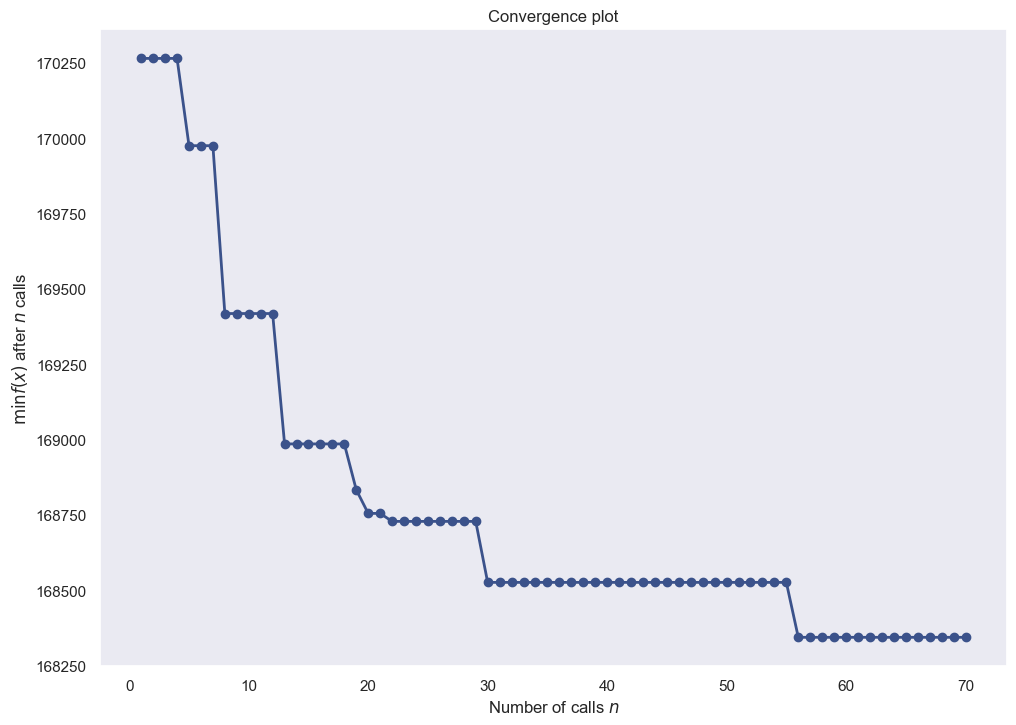

In [37]:
from skopt.plots import plot_objective, plot_histogram, plot_convergence
# Comprobar si la optimización ha convergido
_ = plot_convergence(regr_tree_hpo_bayes.optimizer_results_[0])
plt.show()

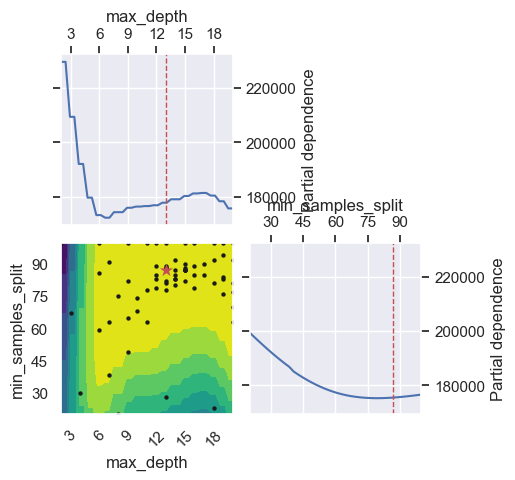

<Figure size 4000x1500 with 0 Axes>

In [38]:
# Visualizar la función objetivo
_ = plot_objective(regr_tree_hpo_bayes.optimizer_results_[0],
                   dimensions=['max_depth', 'min_samples_split'],
                   n_minimum_search=int(1e8))
plt.figure(figsize=(40, 15)) 
plt.show()

In [39]:
y_test_pred = regr_tree_hpo_bayes.predict(X_test)
# Métricas de evaluación
rmse_tree_hpo_bayes = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_tree_hpo_bayes = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE of the tree: {rmse_tree_hpo_bayes}")
print(f"R2 of the tree: {r2_tree_hpo_bayes}")
print(f"Mejores parámetros: {regr_tree_hpo_bayes.best_params_}")

RMSE of the tree: 424.738549203513
R2 of the tree: 0.5813154046849625
Mejores parámetros: OrderedDict([('max_depth', 13), ('min_samples_split', 87)])


Como podemos ver, el rendimiento con este modelo tampoco mejora mucho. Podríamos aumentar el número de iteraciones que realizará la busqueda de hiperparámetros e intentar conseguir que mejore el rendimiento del modelo. Sin embargo, como podemos ver en la gráfica de convergencia,  el valor de la métrica tras cierto número de iteraciones muestra poco cambio. Por este motivo, esta idea se descarta, ya que no obtenedremos beneficios significatos. Además, otro motivo también es por el tiempo de ejecución, que aumentaría innecesariamente.

### Regularización Ridge.

Ahora pasaremos a evaluar el rendimiento del modelo con regularización Ridge. Esta técnica utiliza el parametro *alpha* para imponer una penalización en los coeficientes del modelo. 

In [40]:
param_grid = {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

inner = KFold(n_splits=3, shuffle=True, random_state=49)

regr_ridge_hpo = GridSearchCV(Ridge(),
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=inner,
                         n_jobs=-1, verbose=1
                        )

np.random.seed(49)
inicio = time.time()
regr_ridge_hpo.fit(X=X_train_scaled, y=y_train)
fin = time.time()
t_ridge_hpo = fin - inicio

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [41]:
y_test_pred = regr_ridge_hpo.predict(X_test_scaled)
# Métricas de evaluación
rmse_ridge_hpo = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_ridge_hpo = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmse_ridge_hpo}")
print(f"R2: {r2_ridge_hpo}")
print(f"Mejor parámetro: {regr_ridge_hpo.best_params_}")

RMSE: 539.8418388606162
R2: 0.32364188654474646
Mejor parámetro: {'alpha': 0.3}


### Regularización Lasso.

Por otro lado, evaluaremos el modelo de regresión lineal con regularización Lasso. Al igual que Ridge, también se trata de una técnica que impone una penalización en los coeficientes del modelo, con una pequeña diferencia del anterior, que puede forza a que algunos coeficientes sean cero.

In [42]:
param_grid = {'alpha': [0, 0.001, 0.005, 0.01]}

inner = KFold(n_splits=3, shuffle=True, random_state=49)

regr_lasso_hpo = GridSearchCV(Lasso(max_iter=10000),
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=inner,
                         n_jobs=-1, verbose=1
                        )

np.random.seed(49)
inicio = time.time()
regr_lasso_hpo.fit(X=X_train_scaled, y=y_train)
fin = time.time()
t_lasso_hpo = fin - inicio

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/Users/celia/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/celia/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/celia/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/celia/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/celia/min

/Users/celia/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.138e+08, tolerance: 9.531e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/celia/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.256e+08, tolerance: 9.750e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemente

In [43]:
y_test_pred = regr_lasso_hpo.predict(X_test_scaled)
# Métricas de evaluación
rmse_lasso_hpo = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_lasso_hpo = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmse_lasso_hpo}")
print(f"R2: {r2_lasso_hpo}")
print(f"Mejor parámetro: {regr_lasso_hpo.best_params_}")

RMSE: 539.7612011673475
R2: 0.32384393047974147
Mejor parámetro: {'alpha': 0}


Al realizar la regularización Lasso obtenemos que el mejor parámetro para alpha es 0. Esto significa que es mejor utilizar un modelo estándar de regresión lineal sin regularización Lasso.

In [44]:
# PRUEBAS

from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer

preprocessor = StandardScaler()
pipe_regrLasso = Pipeline([
        ('preproceso', preprocessor),
        ('regresor', LassoCV(
            alphas          = [0, 0.001, 0.1],
            cv              = 3,
            max_iter        = 10000
         ))
])

np.random.seed(49)

pipe_regrLasso.fit(X = X_train, y = y_train)

/Users/celia/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/celia/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 309552632.1138378, tolerance: 95450.05458588191
  model = cd_fast.enet_coordinate_descent_gram(
/Users/celia/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/celia/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_de

Pipeline(steps=[('preproceso', StandardScaler()),
                ('regresor',
                 LassoCV(alphas=[0, 0.001, 0.1], cv=3, max_iter=10000))])

In [45]:
y_test_pred = pipe_regrLasso.predict(X=X_test)

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2 = metrics.r2_score(y_test, y_test_pred)

print(f"RMSE de regresión lineal Lasso: {rmse}")
print(f"R2 de regresión lineal Lasso: {r2}")
print(f"Mejor aplpha: {pipe_regrLasso['regresor'].alpha_}")

RMSE de regresión lineal Lasso: 539.76116837867
R2 de regresión lineal Lasso: 0.323844012628153
Mejor aplpha: 0.001


### Elastic Net

In [46]:
from sklearn.linear_model import ElasticNet

param_grid = {'alpha': [0.001, 0.005, 0.01],
              'l1_ratio': [0.1, 0.5, 0.99]}

inner = KFold(n_splits=3, shuffle=True, random_state=49)

regr_elastic_hpo = GridSearchCV(ElasticNet(),
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=inner,
                         n_jobs=-1, verbose=1
                        )

np.random.seed(49)
inicio = time.time()
regr_elastic_hpo.fit(X=X_train_scaled, y=y_train)
fin = time.time()
t_elastic_hpo = fin - inicio

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/Users/celia/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.854e+08, tolerance: 9.264e+04
  model = cd_fast.enet_coordinate_descent(
/Users/celia/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.155e+08, tolerance: 9.531e+04
  model = cd_fast.enet_coordinate_descent(
/Users/celia/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

In [47]:
y_test_pred = regr_elastic_hpo.predict(X_test_scaled)
# Métricas de evaluación
rmse_elastic_hpo = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_elastic_hpo = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmse_elastic_hpo}")
print(f"R2: {r2_elastic_hpo}")
print(f"Mejor parámetro: {regr_elastic_hpo.best_params_}")

RMSE: 539.7985211881938
R2: 0.32375042605251714
Mejor parámetro: {'alpha': 0.01, 'l1_ratio': 0.99}


### SVM lineal

Como siguiente modelo a evaluar se trata del SVM lineal. Es decir, con el kernel especificado a lineal. Tras el ajuste de su hiperparámetro, hemos obtenido lo siguiente.

In [48]:
param_grid = {'C': [5000, 10000, 15000, 20000]}

inner = KFold(n_splits=3, shuffle=True, random_state=49)

regr_svm_lineal_hpo = GridSearchCV(SVR(kernel="linear"),
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=inner,
                         n_jobs=-1, verbose=1
                        )

np.random.seed(49)
inicio = time.time()
regr_svm_lineal_hpo.fit(X=X_train_scaled, y=y_train)
fin = time.time()
t_svm_lineal_hpo = fin - inicio

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [49]:
y_test_pred = regr_svm_lineal_hpo.predict(X_test_scaled)
# Métricas de evaluación
rmse_svm_lineal_hpo = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_svm_lineal_hpo = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmse_svm_lineal_hpo}")
print(f"R2: {r2_svm_lineal_hpo}")
print(f"Mejor parámetro: {regr_svm_lineal_hpo.best_params_}")

RMSE: 572.5173070770371
R2: 0.23928695583648896
Mejor parámetro: {'C': 10000}


### SVM Radial

El siguiente modelo a evaluar, va a ser el mismo que el anterior, pero el radial. Es decir, el kernel dado por omisión, el radial. Tras el ajuste de hiperparámetros, obtenemos lo siguiente.

In [50]:
param_grid = {'C': [30000, 30500, 40000],
              'gamma': [0.005, 0.01, 0.05]}

inner = KFold(n_splits=3, shuffle=True, random_state=49)

regr_svm_radial_hpo = GridSearchCV(SVR(),
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=inner,
                         n_jobs=-1, verbose=1
                        )

np.random.seed(49)
inicio = time.time()
regr_svm_radial_hpo.fit(X=X_train_scaled, y=y_train)
fin = time.time()
t_svm_radial_hpo = fin - inicio

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [51]:
y_test_pred = regr_svm_radial_hpo.predict(X_test_scaled)
# Métricas de evaluación
rmse_svm_radial_hpo = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_svm_radial_hpo = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmse_svm_radial_hpo}")
print(f"R2: {r2_svm_radial_hpo}")
print(f"Mejor parámetro: {regr_svm_radial_hpo.best_params_}")

RMSE: 360.1636294797408
R2: 0.698946741654539
Mejor parámetro: {'C': 30000, 'gamma': 0.01}


Con este modelo, tras el proceso de ajustar ambos parámetros, obtenemos que una notable mejora en la predicción. Tras la evaluación del modelo, podemos ver como se reduce bastante el valor del RMSE y como aumenta en gran medida el R2, respecto al modelo dummy, al SVM radial con los datos por omisión y al SVM lineal por ajuste de hiperparámetros.

### Random Forest.

In [52]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {'n_estimators': sp_randint(10, 200),
              'max_features': sp_randint(1, X_df.shape[1]),
              'max_depth': sp_randint(2, 20),
              'min_samples_split': sp_randint(2, 20),
              'min_samples_leaf': sp_randint(1, 20)}

inner = KFold(n_splits=3, shuffle=True, random_state=49)

budget = 150
regr_rf_hpo = RandomizedSearchCV(RandomForestRegressor(),
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=inner,
                         refit=True,
                         n_jobs=-1, verbose=1,
                         n_iter = budget
                        )

np.random.seed(49)
inicio = time.time()
regr_rf_hpo.fit(X=X_train_scaled, y=y_train)
fin = time.time()
t_rf_hpo = fin - inicio

Fitting 3 folds for each of 150 candidates, totalling 450 fits


In [53]:
y_test_pred = regr_rf_hpo.predict(X_test_scaled)
# Métricas de evaluación
rmse_rf_hpo = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_rf_hpo = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmse_rf_hpo}")
print(f"R2: {r2_rf_hpo}")
print(f"Mejor parámetro: {regr_rf_hpo.best_params_}")

RMSE: 366.9875904723077
R2: 0.6874306557375077
Mejor parámetro: {'max_depth': 16, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 199}


---
## Tiempos de entrenamiento
---

Para finalizar la evaluación *outer*, veremos los tiempos de entrenamiento obtenidos. Expondremos y analizaremos los tiempos de ejecución junto a los resultados obtenidos de cada modelo para evaluar el rendimiento de cada uno de ellos. Con el fin principal de obtener el modelo final que resuelva este problema de regresión.

In [54]:
# Tomaremos como referencia el modelo Dummy.
tabla_dummy = pd.DataFrame({
    "Modelo": ["Dummy"],
    "RMSE": [rmse_dummy],
    "R2": [r2_dummy],
    "Tiempo": [t_dummy]
})
tabla_dummy

,Modelo,RMSE,R2,Tiempo
0,Dummy,692.091301,-0.111656,0.000683


In [55]:
# Resultado de los modelos sin HPO.
tabla_sin_hpo = pd.DataFrame({
    "RMSE": [rmse_knn_scaled, rmse_lineal, rmse_tree, rmse_linear_tree, rmse_ridge, rmse_lasso, rmse_svm_lineal, rmse_svm_radial],
    "R2": [r2_knn_scaled, r2_lineal, r2_tree, r2_linear_tree, r2_ridge, r2_lasso, r2_svm_lineal, r2_svm_radial],
    "Tiempo": [t_knn, t_lineal, t_tree, t_linear_tree, t_ridge, t_lasso, t_svm_lineal, t_svm_radial]
}, index = ["KNN", "Regresión lineal", "Árbol de decisión", "Árbol con regresión lineal", "Regularización ridge", "Regularización lasso", "SVM lineal", "SVM radial"])

In [56]:
# Resultados de los modelos con HPO.
tabla_hpo = pd.DataFrame({
    "RMSE": [rmse_knn_hpo, rmse_tree_hpo, rmse_tree_hpo_bayes, rmse_ridge_hpo, rmse_lasso_hpo, rmse_svm_lineal_hpo, rmse_svm_radial_hpo],
    "R2": [r2_knn_hpo, r2_tree_hpo, r2_tree_hpo_bayes, r2_ridge_hpo, r2_lasso_hpo, r2_svm_lineal_hpo, r2_svm_radial_hpo],
    "Tiempo": [t_knn_hpo, t_tree_hpo, t_tree_hpo_bayes, t_ridge_hpo, t_lasso_hpo, t_svm_lineal_hpo, t_svm_radial_hpo]
}, index = ["KNN", "Árbol de decisión", "Árbol de decisión Bayes", "Regularización ridge", "Regularización lasso", "SVM lineal", "SVM radial"])

Unificaremos las tablas en una sola para ver mejor los resultados. A la izquierda quedan los resultados sin ajuste de hiperparámetros y a la derecha los ajustados. Adicionalmente, con fines simplemente visuales, se ha decidido eliminar los *NaN* y sustituirlos por guiones.

In [57]:
# Unificamos ambas tablas en una sola.
tabla = pd.concat([tabla_sin_hpo, tabla_hpo], axis=1)
tabla = tabla.fillna('-')
tabla

,RMSE,R2,Tiempo,RMSE,R2,Tiempo
KNN,402.549875,0.623918,0.00062,397.225509,0.6338,1.702789
Regresión lineal,539.761203,0.323844,0.003808,-,-,-
Árbol de decisión,509.815211,0.396789,0.18567,423.624316,0.583509,2.962071
Árbol con regresión lineal,383.133115,0.659323,167.292772,-,-,-
Regularización ridge,540.102024,0.32299,0.019261,539.841839,0.323642,0.072065
Regularización lasso,540.102024,0.32299,0.006265,539.761201,0.323844,3.418712
SVM lineal,587.1541,0.199893,0.498215,572.517307,0.239287,39.276673
SVM radial,632.148868,0.072567,0.434421,360.163629,0.698947,21.426718
Árbol de decisión Bayes,-,-,-,424.738549,0.581315,140.937998


---
## Modelo final.
---

Para realizar el modelo final de este caso práctico de predicción, la mejor alternativa que hemos obtenido es el modelo SVM radial.

In [58]:
wind_ava = pd.read_csv('wind_ava.csv.gz', compression="gzip")
# Separación de variables de entrada y de salida.
X_final = wind_ava.filter(regex='.13$')
y_final = wind_ava['energy']

In [59]:
# Escalar los datos
scaler = StandardScaler()
X_final_scaled = scaler.fit_transform(X_final)

In [60]:
# División de los datos en entrenamiento y test.
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final_scaled, y_final, test_size=0.33, random_state=49)

In [61]:
# Creamos el modelo final
regr_final = regr_svm_radial_hpo
# Con los mejores parámetros obtenidos
best_params = regr_svm_radial_hpo.best_params_
regr_final = SVR(**best_params)
# Entrenamos el modelo final
regr_final.fit(X_train_final, y_train_final)

SVR(C=30000, gamma=0.01)

In [62]:
# Realizamos las predicciones
y_test_pred = regr_final.predict(X_test_final)
# Evaluamos el rendimiento del modelo
rmse_final = np.sqrt(metrics.mean_squared_error(y_test_final, y_test_pred))
r2_final = metrics.r2_score(y_test_final, y_test_pred)
# Imprimimos el resultado
print(f"RMSE del modelo final: {rmse_final}")
print(f"R2 del modelo final: {r2_final}")

RMSE del modelo final: 360.1636294797408
R2 del modelo final: 0.698946741654539


Para entregar el modelo final. Entrenamos con todos los datos.

In [63]:
regr_final.fit(X_final_scaled, y_final)

SVR(C=30000, gamma=0.01)

In [64]:
# Guardarlo en un fichero.
import pickle
with open('modelo_final.pkl', 'wb') as file:
    pickle.dump(regr_final, file)

A continuación, utilizaremos el modelo final para realizar predicciones para el conjunto de datos del problema.

In [65]:
wind_comp = pd.read_csv('wind_comp.csv.gz', compression="gzip")
# Separación de variables de entrada y de salida.
X_comp = wind_comp.filter(regex='.13$')

In [66]:
# Escalar los datos.
X_comp_scaled = scaler.fit_transform(X_comp)

In [67]:
# Realizamos las predicciones
y_test_pred = regr_final.predict(X_comp_scaled)

In [68]:
# Guardar el modelo en un fichero csv.
import csv
with open('predicciones.csv', mode='w') as file:
    writer = csv.writer(file)
    writer.writerow(["predicciones"])
    for pred in y_test_pred:
        writer.writerow([pred])

In [69]:
# Variable de salida
y_comp = wind_comp['energy']
# Evaluamos el rendimiento del modelo
rmse_final = np.sqrt(metrics.mean_squared_error(y_comp, y_test_pred))
r2_final = metrics.r2_score(y_comp, y_test_pred)
# Imprimimos el resultado
print(f"RMSE del modelo final: {rmse_final}")
print(f"R2 del modelo final: {r2_final}")

RMSE del modelo final: 397.3396387785031
R2 del modelo final: 0.683540188557521


---
## Converisón a un problema de clasificación.
---

En la siguiente sección, convertiremos el problema de regresión en uno de clasificación. Esto lo haremos de la siguiente manera: cuando la energía sea menor que el tercer cuantil, se considerará clase “baja”, y cuando sea mayor, clase “alta”.

In [70]:
df = wind_ava.filter(regex='.13$').copy()
df['energy'] = wind_ava['energy'].copy()

In [71]:
# Calcular el tercer cuartil de la variable 'energy'
tercer_cuartil = df['energy'].quantile(0.75)

In [72]:
# Filtrar los datos donde 'energy' sea menor o igual al tercer cuartil (energia_baja)
energia_baja = df[df['energy'] <= tercer_cuartil]
energia_baja.head()

,p54.162.13,p55.162.13,cape.13,p59.162.13,lai_lv.13,lai_hv.13,u10n.13,v10n.13,sp.13,stl1.13,...,stl2.13,stl3.13,iews.13,inss.13,stl4.13,fsr.13,flsr.13,u100.13,v100.13,energy
0,2.510824e+06,9.186295,13.527577,1.386937e+06,2.344111,2.432983,-0.757587,-1.922799,99846.319914,280.960661,...,281.042026,281.462478,-0.057958,-0.138650,284.684755,0.404731,-5.927092,-1.780562,-4.443617,402.71
1,2.513173e+06,8.849569,6.896412,1.153526e+06,2.343719,2.432838,-1.412620,-1.403011,99917.733093,279.296651,...,280.747406,281.486541,-0.103576,-0.083050,284.667948,0.404920,-5.913881,-3.743344,-3.129469,696.80
4,2.505664e+06,6.646282,0.000000,1.070830e+06,2.342437,2.432369,-0.971249,0.553060,99372.811211,279.583112,...,280.576898,281.473265,-0.056553,0.041844,284.620232,0.403808,-5.987860,-3.392324,2.131114,562.50
5,2.505768e+06,6.125948,0.000000,1.094100e+06,2.342045,2.432235,-0.153568,1.554043,99257.763690,276.620140,...,279.654761,281.464691,0.003361,0.144389,284.603425,0.404758,-5.957546,0.190590,5.349629,232.30
6,2.503477e+06,7.038564,0.000000,1.264504e+06,2.341653,2.432090,1.247802,1.676775,99277.551356,276.140000,...,278.712132,281.416011,0.115504,0.144389,284.585652,0.406001,-5.957198,4.105168,4.612229,329.95


In [73]:
# Filtrar los datos donde 'energy' sea mayor que el tercer cuartil (energia_alta)
energia_alta = df[df['energy'] > tercer_cuartil]
energia_alta.head()

,p54.162.13,p55.162.13,cape.13,p59.162.13,lai_lv.13,lai_hv.13,u10n.13,v10n.13,sp.13,stl1.13,...,stl2.13,stl3.13,iews.13,inss.13,stl4.13,fsr.13,flsr.13,u100.13,v100.13,energy
2,2.509627e+06,7.924080,4.774439,1.098754e+06,2.343300,2.432704,-2.290185,-0.754580,99764.378681,278.233956,...,280.114863,281.487095,-0.165721,-0.036241,284.651914,0.405704,-5.908272,-5.097203,-1.157748,1591.15
3,2.510571e+06,6.922709,0.000000,1.076021e+06,2.342830,2.432514,-3.497855,1.271028,99672.670459,280.787263,...,279.991138,281.472435,-0.275550,0.098192,284.636266,0.403967,-5.961995,-4.500835,1.502478,1338.62
19,2.501566e+06,5.069699,0.000000,2.231439e+06,2.335507,2.429933,2.058460,4.320565,98937.989932,277.694496,...,279.689559,281.227375,0.296734,0.562065,284.334515,0.408046,-6.009090,3.930966,8.244346,1524.05
27,2.490700e+06,6.122561,0.000000,1.121844e+06,2.332212,2.428771,1.433000,4.239903,98552.257286,278.051432,...,280.170539,281.192801,0.215333,0.535969,284.205662,0.408767,-6.000770,3.114884,8.642482,1434.55
32,2.489981e+06,19.044174,0.000000,9.698767e+05,2.330119,2.428012,0.958361,5.837511,98741.381710,279.586661,...,280.399430,281.176482,0.227068,0.739084,284.127423,0.422033,-5.820874,2.386688,9.411813,1164.17


### Energía baja.

In [74]:
X_baja = energia_baja.drop(columns='energy')
y_baja = energia_baja['energy']

In [75]:
# Escalar
scaler = StandardScaler()
X_baja_scaled = scaler.fit_transform(X_baja)

# Dividir los datos en entrenamiento y test
X_train_baja, X_test_baja, y_train_baja, y_test_baja = train_test_split(X_baja_scaled, y_baja, test_size=0.33, random_state=49)


In [76]:
param_grid = {'C': [2000, 4000, 6000, 8000, 10000],
              'gamma': [0.001, 0.005, 0.01, 0.05, 0.1]}

inner = KFold(n_splits=3, shuffle=True, random_state=49)

regrBaja_svm_radial_hpo = GridSearchCV(SVR(),
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=inner,
                         n_jobs=-1, verbose=1
                        )

np.random.seed(49)
regrBaja_svm_radial_hpo.fit(X=X_train_baja, y=y_train_baja)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=49, shuffle=True),
             estimator=SVR(), n_jobs=-1,
             param_grid={'C': [2000, 4000, 6000, 8000, 10000],
                         'gamma': [0.001, 0.005, 0.01, 0.05, 0.1]},
             scoring='neg_mean_squared_error', verbose=1)

In [77]:
y_test_pred = regrBaja_svm_radial_hpo.predict(X_test_baja)
# Métricas de evaluación
rmseBaja_svm_radial_hpo = np.sqrt(metrics.mean_squared_error(y_test_baja, y_test_pred))
r2Baja_svm_radial_hpo = metrics.r2_score(y_test_baja, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmseBaja_svm_radial_hpo}")
print(f"R2: {r2Baja_svm_radial_hpo}")
print(f"Mejor parámetro: {regrBaja_svm_radial_hpo.best_params_}")

RMSE: 242.45095959401831
R2: 0.4185306563704383
Mejor parámetro: {'C': 6000, 'gamma': 0.01}


### Energia alta.

In [78]:
X_alta = energia_alta.drop(columns='energy')
y_alta = energia_alta['energy']

In [79]:
# Escalar
scaler = StandardScaler()
X_alta_scaled = scaler.fit_transform(X_alta)

# Dividir los datos en entrenamiento y test
X_train_alta, X_test_alta, y_train_alta, y_test_alta = train_test_split(X_alta_scaled, y_alta, test_size=0.33, random_state=49)


In [80]:
param_grid = {'C': [1000, 5000, 10000, 30000, 50000],
              'gamma': [0.001, 0.005, 0.01, 0.05]}

inner = KFold(n_splits=3, shuffle=True, random_state=49)

regrAlta_svm_radial_hpo = GridSearchCV(SVR(),
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=inner,
                         n_jobs=-1, verbose=1
                        )

np.random.seed(49)
regrAlta_svm_radial_hpo.fit(X=X_train_alta, y=y_train_alta)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=49, shuffle=True),
             estimator=SVR(), n_jobs=-1,
             param_grid={'C': [1000, 5000, 10000, 30000, 50000],
                         'gamma': [0.001, 0.005, 0.01, 0.05]},
             scoring='neg_mean_squared_error', verbose=1)

In [81]:
y_test_pred = regrAlta_svm_radial_hpo.predict(X_test_alta)

# Métricas de evaluación
rmseAlta_svm_radial_hpo = np.sqrt(metrics.mean_squared_error(y_test_alta, y_test_pred))
r2Alta_svm_radial_hpo = metrics.r2_score(y_test_alta, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmseAlta_svm_radial_hpo}")
print(f"R2: {r2Alta_svm_radial_hpo}")
print(f"Mejor parámetro: {regrAlta_svm_radial_hpo.best_params_}")

RMSE: 342.11544826485164
R2: 0.27257493237842056
Mejor parámetro: {'C': 5000, 'gamma': 0.01}


### Conclusiones.

Hemos obtenido que para nuestro problema las predicciones para valores bajos son mejores que para valores altos. Como pudimos ver con el histograma de la distribución de la variable de salida, nuestro conjunto de datos tiene más ejemplos de valores bajos de energía que altos por lo que las predicciones serán más precisas para dichos valores.

### Resolución.

Para resolver este problema de clasificación utilizaremos el modelo de regresión logística e intentaremos obtener los mejores resultados.

In [82]:
energia_baja.loc[:, 'energy'] = 0
energia_alta.loc[:, 'energy'] = 1

# Unimos los dos conjuntos de datos
df_clf = pd.concat([energia_baja, energia_alta])

In [83]:
# Dividimos entre variables de entrada y de salida
X_clf = df_clf.drop(columns='energy')
y_clf = df_clf['energy']

In [84]:
# Dividimos los datos en entrenamiento y test
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.33, random_state=49)

In [85]:
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()       # escalar
lr = LogisticRegression(penalty='none', random_state = 49)      # modelo

pipe_scale_lr = Pipeline([
    ('scale', scaler),
    ('lr', lr)])

In [86]:
param_grid = [{'lr__penalty': ['l1', 'l2', 'elascticnet'],
               'lr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
               'lr__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}]

inner = KFold(n_splits=3, shuffle=True, random_state=42)

#budget = 40
# Cross-validation (3-fold) para la búsqueda de hiper-parámetros
clf = GridSearchCV (estimator  = pipe_scale_lr,
                    param_grid = param_grid,
                    scoring='accuracy', #OJO!!! scoring=‘balanced_accuracy’
                    cv=inner,
                    refit=True,
                    n_jobs=-1,
                    verbose=1,
                    return_train_score=True)

np.random.seed(42)

clf.fit(X=X_train_clf, y=y_train_clf)

Fitting 3 folds for each of 105 candidates, totalling 315 fits


/Users/celia/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/celia/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

/Users/celia/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/celia/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/celia/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/celia/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/celia/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/celia/miniconda3/lib/python3.8/site-packages/sklearn/linea

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(penalty='none',
                                                           random_state=49))]),
             n_jobs=-1,
             param_grid=[{'lr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'lr__penalty': ['l1', 'l2', 'elascticnet'],
                          'lr__solver': ['newton-cg', 'lbfgs', 'liblinear',
                                         'sag', 'saga']}],
             return_train_score=True, scoring='accuracy', verbose=1)

In [87]:
resultados = pd.DataFrame(clf.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head()

,param_lr__C,param_lr__penalty,param_lr__solver,mean_test_score,std_test_score,mean_train_score,std_train_score
52,1,l2,liblinear,0.817668,0.002886,0.820183,0.002406
51,1,l2,lbfgs,0.817353,0.003185,0.820340,0.002628
50,1,l2,newton-cg,0.817353,0.003185,0.820497,0.002524
94,1000,l1,saga,0.817353,0.002448,0.821283,0.002656
84,100,l2,saga,0.817353,0.002448,0.821283,0.002656


In [88]:
clf.best_params_, clf.best_score_

({'lr__C': 1, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'},
 0.817667858137867)

In [89]:
modelo_final = clf.best_estimator_
print("Intercept:", modelo_final['lr'].intercept_)
print("Coeficientes:", list(zip(df_clf.columns, modelo_final['lr'].coef_.flatten(), )))
print("Accuracy de test:", modelo_final.score(X_test_clf, y_test_clf))

Intercept: [-1.3875758]
Coeficientes: [('p54.162.13', 0.5094636737092664), ('p55.162.13', 0.06986842327252403), ('cape.13', -0.15084883808817492), ('p59.162.13', 0.8249856491846308), ('lai_lv.13', 0.45544361097700803), ('lai_hv.13', -0.588990668515902), ('u10n.13', -1.8607389207662741), ('v10n.13', 0.6090827930927385), ('sp.13', -0.3166480262848288), ('stl1.13', -0.2758083834072767), ('u10.13', 2.129631677375796), ('v10.13', -1.7753585168696826), ('t2m.13', -0.15275941010503305), ('stl2.13', -0.3134469951287579), ('stl3.13', 0.028118872648600978), ('iews.13', 0.7269467391576517), ('inss.13', 0.672877150221534), ('stl4.13', 0.003636461178932267), ('fsr.13', 1.512362577963538), ('flsr.13', -1.3786169026736952), ('u100.13', -1.0120405964355341), ('v100.13', 0.7346790461447331)]
Accuracy de test: 0.8155711550733886


In [90]:
y_test_pred = modelo_final.predict(X_test_clf)
result = metrics.classification_report(y_test_clf, y_test_pred)
print("Classification Report:",)
print (result)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.95      0.88      1171
         1.0       0.73      0.43      0.54       396

    accuracy                           0.82      1567
   macro avg       0.78      0.69      0.71      1567
weighted avg       0.80      0.82      0.80      1567



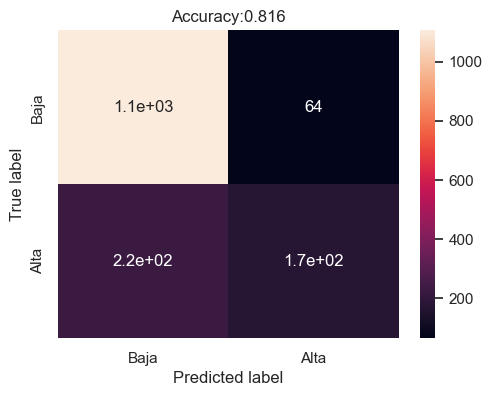

In [91]:
# Creates a confusion matrix
cm = metrics.confusion_matrix(y_test_clf, y_test_pred)
accuracy = metrics.accuracy_score(y_test_clf, y_test_pred)
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Baja','Alta'],
                     columns = ['Baja','Alta'])
plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Accuracy:{0:.3f}'.format(accuracy))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

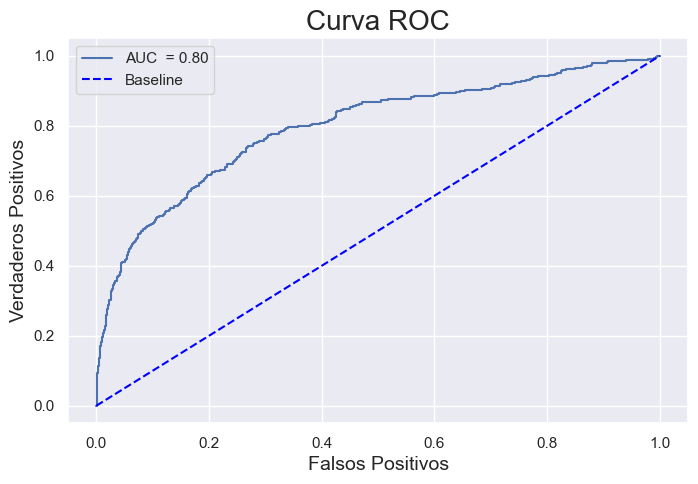

In [92]:
#Obtenemos las curva ROC y el área bajo la curva (AUC)

probs = clf.predict_proba(X_test_clf)[:, 1]

auc = metrics.roc_auc_score(y_test_clf, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test_clf, probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend()

#### Random Forest.

In [93]:
from sklearn.ensemble import RandomForestClassifier

scaler = StandardScaler()       # escalar
rf = RandomForestClassifier(random_state = 49)      # modelo

pipe_scale_rf = Pipeline([
    ('scale', scaler),
    ('rf', rf)])

In [113]:
param_grid = {'rf__n_estimators': [10, 20, 30, 40, 50],
              'rf__max_depth': [1, 10, 30, 50],
              'rf__min_samples_split': [2, 10, 20],
              'rf__min_samples_leaf': [1, 5, 10, 15, 20]}

inner = KFold(n_splits=3, shuffle=True, random_state=49)

#budget = 40
# Cross-validation (3-fold) para la búsqueda de hiper-parámetros
clf_rf = GridSearchCV (estimator  = pipe_scale_rf,
                    param_grid = param_grid,
                    scoring='accuracy', #OJO!!! scoring=‘balanced_accuracy’
                    cv=inner,
                    refit=True,
                    n_jobs=-1,
                    verbose=1,
                    return_train_score=True)

np.random.seed(49)

clf_rf.fit(X=X_train_clf, y=y_train_clf)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=49, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(random_state=49))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [1, 10, 30, 50],
                         'rf__min_samples_leaf': [1, 5, 10, 15, 20],
                         'rf__min_samples_split': [2, 10, 20],
                         'rf__n_estimators': [10, 20, 30, 40, 50]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [114]:
resultados = pd.DataFrame(clf_rf.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head()

,param_rf__max_depth,param_rf__min_samples_leaf,param_rf__min_samples_split,param_rf__n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
89,10,1,20,50,0.877711,0.008935,0.934769,0.000788
88,10,1,20,40,0.876140,0.010021,0.936498,0.001607
122,10,15,2,30,0.875825,0.012335,0.902546,0.003129
127,10,15,10,30,0.875825,0.012335,0.902546,0.003129
132,10,15,20,30,0.875825,0.012335,0.902546,0.003129


In [115]:
clf_rf.best_params_, clf_rf.best_score_

({'rf__max_depth': 10,
  'rf__min_samples_leaf': 1,
  'rf__min_samples_split': 20,
  'rf__n_estimators': 50},
 0.8777108933662915)

In [118]:
modelo_rf = clf_rf.best_estimator_
print("Importances:", modelo_rf['rf'].feature_importances_)
print("Accuracy de test:", modelo_rf.score(X_test_clf, y_test_clf))

Importances: [0.01329899 0.01929313 0.00789978 0.06127002 0.01259275 0.01515528
 0.10162051 0.0493284  0.01268919 0.02369616 0.08577985 0.03996151
 0.03107942 0.01633547 0.0135414  0.15599341 0.07107473 0.01210577
 0.02573163 0.02790768 0.16216349 0.04148145]
Accuracy de test: 0.8813018506700702


#### Conclusiones

Como podemos ver la precisión que se obtiene es mejor en los valores bajos de energía que en los valores altos, coincidiendo con los que hemos concluido anteriormente. Por otro lado, la recuperación o *recall* que se obtiene es significativamente mejor para valores bajos, es decir, que son clasificados mejor (cuando el modelo predice que son de esa clase y realmente lo son).

### Desbalance.

Veamos la frecuencia de cada clase para ver si se trata de un problema desbalanceado.

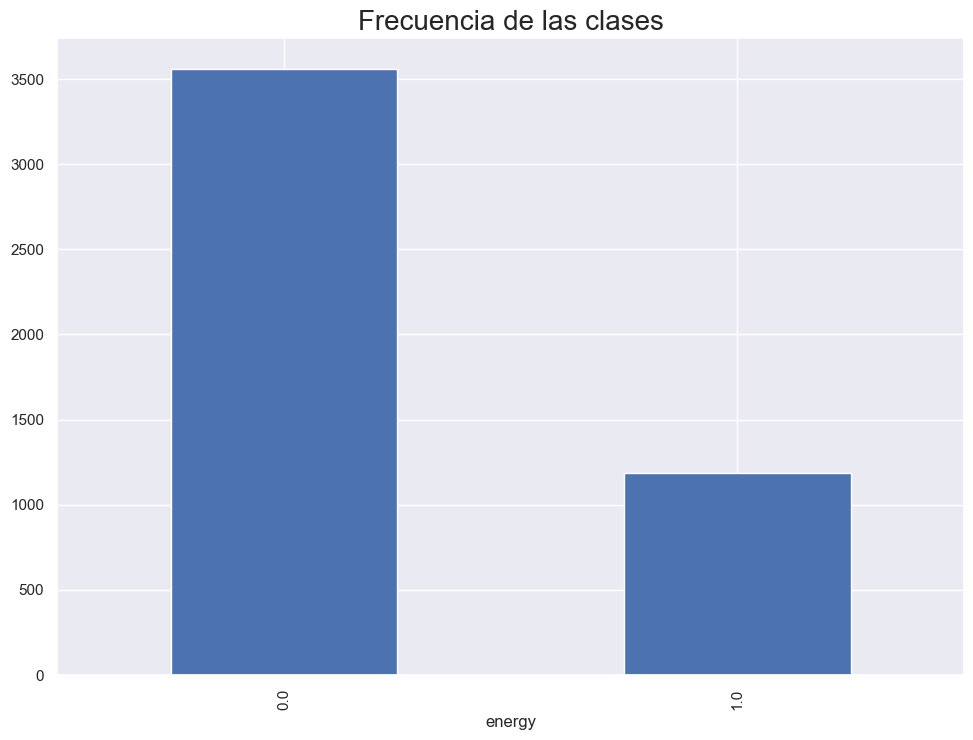

In [112]:
df_clf['energy'].value_counts().sort_index().plot(kind='bar')
plt.title('Frecuencia de las clases', size=20)
plt.show()

Como podemos observar, nuestro problema se trata de un problema de clasificación desbalanceado por lo que utilizaremos métodos para abordar este problema como *HistGradientBoostingClassifier* con valores por defecto.

In [105]:
from sklearn.ensemble import HistGradientBoostingClassifier

clf_gb = HistGradientBoostingClassifier()

np.random.seed(49)
clf_gb.fit(X_train_clf, y_train_clf)

HistGradientBoostingClassifier()

In [106]:
y_test_pred = clf_gb.predict(X_test_clf)
result = metrics.classification_report(y_test_clf, y_test_pred)
print("Classification Report:",)
print (result)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92      1171
         1.0       0.79      0.70      0.75       396

    accuracy                           0.88      1567
   macro avg       0.85      0.82      0.83      1567
weighted avg       0.88      0.88      0.88      1567



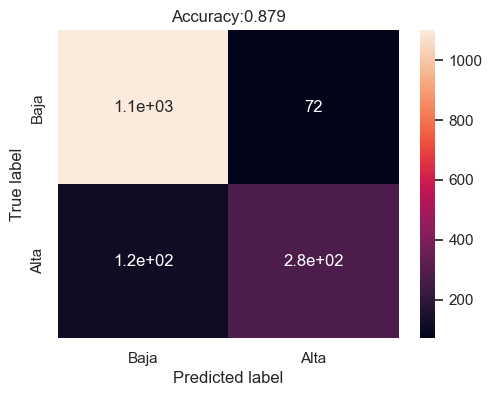

In [107]:
# Creates a confusion matrix
cm = metrics.confusion_matrix(y_test_clf, y_test_pred)
accuracy = metrics.accuracy_score(y_test_clf, y_test_pred)
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Baja','Alta'],
                     columns = ['Baja','Alta'])
plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Accuracy:{0:.3f}'.format(accuracy))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Como podemos ver, se produce una mejora significativa.

#### Busqueda de hiperparámetros

Veamos si con el ajuste y búsqueda de hiperparámetros mejora aún más.

In [148]:
param_grid = {'max_depth'         : [None, 1, 3, 5, 10, 20, 30],
              'learning_rate'     : [0.001, 0.05, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
              'l2_regularization' : [0, 1, 2],
              'max_leaf_nodes'    : [2, 3, 5, 10, 15],
              'min_samples_leaf'  : [10, 15, 20, 25, 30]
             }

inner = KFold(n_splits=3, shuffle=True, random_state=42)

budget = 80
# Cross-validation (3-fold) para la búsqueda de hiper-parámetros
clf_gb_hpo = RandomizedSearchCV (estimator  = HistGradientBoostingClassifier(max_iter     = 1000,
                                                                      random_state        = 49,
                                                                      validation_fraction = 0.1,
                                                                      n_iter_no_change    = 5,
                                                                      tol                 = 0.0001),
                           param_distributions = param_grid,
                           scoring="balanced_accuracy",
                           cv=inner,
                           refit=True,
                           n_jobs=-1,
                           verbose=1,
                           n_iter=budget,
                           return_train_score=True)

np.random.seed(49)
clf_gb_hpo.fit(X=X_train_clf, y=y_train_clf)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=HistGradientBoostingClassifier(max_iter=1000,
                                                            n_iter_no_change=5,
                                                            random_state=49,
                                                            tol=0.0001),
                   n_iter=80, n_jobs=-1,
                   param_distributions={'l2_regularization': [0, 1, 2],
                                        'learning_rate': [0.001, 0.05, 0.01,
                                                          0.1, 0.2, 0.3, 0.4,
                                                          0.5, 0.6, 0.7, 0.8,
                                                          0.9],
                                        'max_depth': [None, 1, 3, 5, 10, 20,
                                                      30],
                                        'max_leaf_nodes': [2, 3, 5, 10, 15],
                                        'min_samples_leaf': [10, 15, 20, 25,
                                                             30]},
                   return_train_score=True, scoring='balanced_accuracy',
                   verbose=1)

In [149]:
# Mostrar los mejores parametros
clf_gb_hpo.best_params_, clf_gb_hpo.best_score_

({'min_samples_leaf': 15,
  'max_leaf_nodes': 5,
  'max_depth': 10,
  'learning_rate': 0.01,
  'l2_regularization': 2},
 0.8186186674837339)

In [150]:
y_test_pred = clf_gb_hpo.predict(X_test_clf)
result = metrics.classification_report(y_test_clf, y_test_pred)
print("Classification Report:",)
print (result)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92      1171
         1.0       0.81      0.70      0.75       396

    accuracy                           0.88      1567
   macro avg       0.86      0.82      0.84      1567
weighted avg       0.88      0.88      0.88      1567



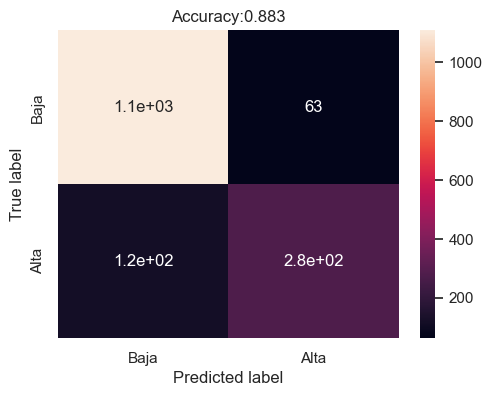

In [151]:
# Creates a confusion matrix
cm = metrics.confusion_matrix(y_test_clf, y_test_pred)
accuracy = metrics.accuracy_score(y_test_clf, y_test_pred)
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Baja','Alta'],
                     columns = ['Baja','Alta'])
plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Accuracy:{0:.3f}'.format(accuracy))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()